Automatic memoization in python
===============================

[Memoization](https://en.wikipedia.org/wiki/Memoization) (a key concept in [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming)) is a fancy word that basically means storing the results of computation and never recomputing. Instead, you simply look up the already computed value. Any [pure function](https://en.wikipedia.org/wiki/Pure_function) can be memoized.

Memoization can have a dramatic affect on the runtime of algorithms which use the results of computation multiple times.

#### A classic example ####

The [Fibonacci sequence](https://en.wikipedia.org/wiki/Fibonacci_number) is a famous and very old sequence of numbers given by:

$$
\begin{align}
    F_0 &= 1                 \\
    F_1 &= 1                 \\
    F_n &= F_{n-1} + F_{n-2} \\
\end{align}
$$

This sequence has interesting connections to all kinds of mathematics, but that's another post altogether.

For now, lets implement it in python!

Here is a definition that is quite faithful to its mathematical definition:

In [1]:
def fib(n):
    return 1 if n < 2 else fib(n - 1) + fib(n - 2)

Elegant and unquestionably correct.

Lets take it for a test drive.

In [2]:
print [fib(n) for n in xrange(10)]

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55]


Cool! That seems to be working well.

Wait. How well does this perform?

In [3]:
%timeit fib(35)

1 loop, best of 3: 3.39 s per loop


Holy cow that's slow!

To understand why, take a look at the call graph of `fib(6)`

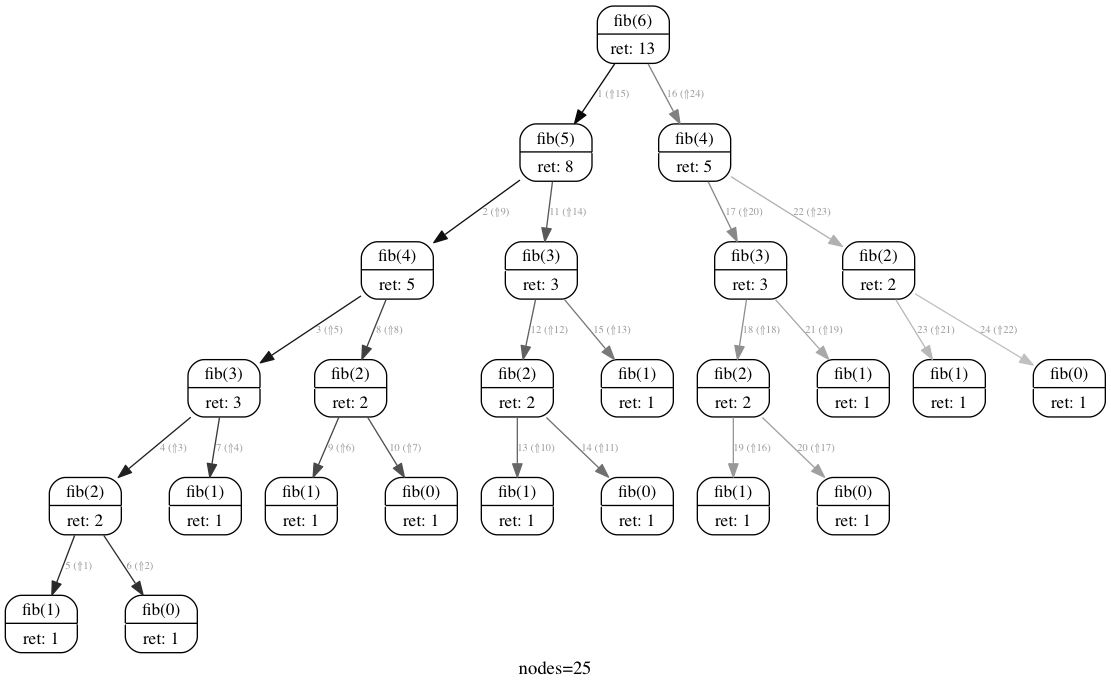

In [4]:
from IPython.display import Image
Image(filename='fib_6_callgraph.png') 

Take a look at all that recomputation! It's diabolical! All we really need is the far left depth first traversal, but the algorithm has no way of knowing that.

Let's fix that.

In [5]:
memoized_fib_values = {}

def memoized_fib(n):
    if n < 2:
        return 1

    if memoized_fib_values.get(n):
        return memoized_fib_values[n]
    
    memoized_fib_values[n] = memoized_fib(n - 1) + memoized_fib(n - 2)
    return memoized_fib_values[n]

print [memoized_fib(n) for n in xrange(10)]

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55]


Ok, so far so good. How much better is our performance?

In [6]:
%timeit memoized_fib(35)

The slowest run took 122.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 261 ns per loop


Hmmm. That's an interesting result. The `%timeit` function noticed that there was a huge difference between the slowest and the fastest run. That's because `%timeit` runs the code a bunch of times to give you a more accurate result. In our case, once `memoized_fib(35)` was computed once, it was never computed again. Further function calls were simply a dictionary lookup.

Let's roll our own timing function to get a feel for how much we gained.

In [7]:
import time

def simple_timeit(f, *args, **kwargs):
    initital_time = time.time()
    f(*args, **kwargs)
    print '{} took {} miliseconds'.format(f.__name__, (time.time() - initital_time) * 1000)

memoized_fib_values = {}
simple_timeit(fib, 35)
simple_timeit(memoized_fib, 35)
simple_timeit(memoized_fib, 35)


fib took 3429.04305458 miliseconds
memoized_fib took 0.0250339508057 miliseconds
memoized_fib took 0.000953674316406 miliseconds


Awesome!

The memoized version of `fib` took about five orders of magnitude less time than the original! (We changed the runtime of the algorithm from exponential to linear.)

Also, note that the second call to `memoized_fib` was an order of magnitude faster than the first call. That's because it was just a dictionary lookup.

While the performance benefits are impressive, the implementation of the memoized version leaves something to be desired. It relies on a global dictionary to store computation results and it has lost the simple elegance and mathematical purity of the original implementation.

Is it possible to have the best of both worlds?

Yes, yes it is. :)

Let's write a decorator to abstact away all the gory details of memoization.

In [8]:
import functools

def memoize(f):
    computed = {}
    @functools.wraps(f)
    def memoized_f(main_arg, *args, **kwargs):
        if computed.get(main_arg):
            return computed[main_arg]
        computed[main_arg] = f(main_arg, *args, **kwargs)
        return computed[main_arg]
    return memoized_f

`memoize` is a [higher order function](https://en.wikipedia.org/wiki/Higher-order_function) and so we can use it as a decorator.

Note that `memoized_f` is a [closure](https://en.wikipedia.org/wiki/Closure_(computer_programming&#41;) and it captures the `computed` variable. This eliminates the need for a global variable to hold the computed values.

Also, note the `*args` and `**kwargs` parameters. This allows functions which take more than one parameter and functions that take keyword arguments to be decorated with `@memoize`. However, it is important to take note that the memoized computation is determined *solely* by the `main_arg` parameter. i.e., if you decorate a function with `@memoize` that takes multiple arguments, you had better always call that function with those parameters if they change the resulting value or else you will get incorrect results.

If you wanted, you could modify `memoize` to set the keys to `computed` to be some combination (or a hash) of all the parameters, but I'll leave that as an exercise for the reader.

For now, lets try out the decorator!

In [9]:
@memoize
def fib(n):
    return 1 if n < 2 else fib(n - 1) + fib(n - 2)

simple_timeit(fib, 35)
simple_timeit(fib, 35)

fib took 0.191926956177 miliseconds
fib took 0.000953674316406 miliseconds


Sweet!

Now we have the elegance of the original and the performance of the hand-crafted memoized version. We also have a reusable tool that can apply to any pure function. If you determine that a particular function is causing you a performance hit, consider memoization.

Lets look at one last example.

We can apply the `@memoize` decorator to any function we want!

Lets consider the `math.factorial` function:

In [10]:
from math import factorial

memoized_factorial = memoize(factorial)

print "math.factorial(100000) runtimes:"
simple_timeit(factorial, 100000)
simple_timeit(factorial, 100001)

print "\nmemoized(math.factorial(100000)) runtimes:"
simple_timeit(memoized_factorial, 100000)
simple_timeit(memoized_factorial, 100000)

math.factorial(100000) runtimes:
factorial took 2777.85110474 miliseconds
factorial took 2858.99400711 miliseconds

memoized(math.factorial(100000)) runtimes:
factorial took 2846.65703773 miliseconds
factorial took 0.00190734863281 miliseconds


As you can see, the original version always recomputes the value, but our memoized version just tells us the falue if it already knows the answer.

The tradeoff is that you are storing the computation results in a dictionary. Be aware of the fact that you are trading computation time for memory space. Somtimes the tradeoff is well worth it but sometimes it might not be.

Cheers!